Base on https://www.kaggle.com/artgor/quick-and-dirty-regression @artgor

Please upvote the original kernel, thanks. 👋

## Importing libraries

In [1]:
import numpy as np
import pandas as pd

import random
random.seed(1029)
np.random.seed(1029)

import os
import copy
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm_notebook
from sklearn.preprocessing import StandardScaler
from sklearn.svm import NuSVR, SVR
from sklearn.metrics import mean_absolute_error
pd.options.display.precision = 15
from collections import defaultdict
import lightgbm as lgb
import xgboost as xgb
import catboost as cat
import time
from collections import Counter
import datetime
from catboost import CatBoostRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold, GroupKFold, GridSearchCV, train_test_split, TimeSeriesSplit, RepeatedStratifiedKFold
from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix
from sklearn import linear_model
import gc
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from bayes_opt import BayesianOptimization
import eli5
import shap
from IPython.display import HTML
import json
import altair as alt
from category_encoders.ordinal import OrdinalEncoder
import networkx as nx
import matplotlib.pyplot as plt
%matplotlib inline
from typing import List

import os
import time
import datetime
import json
import gc
from numba import jit
import pickle

from functools import partial
import scipy as sp

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm_notebook

import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor, CatBoostClassifier
from sklearn import metrics
from typing import Any
from itertools import product
pd.set_option('max_rows', 500)
import re
from tqdm import tqdm
from joblib import Parallel, delayed

/Users/s.imazeki/.pyenv/versions/anaconda3-5.3.1/lib/python3.7/site-packages/lightgbm/__init__.py:48: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)
Using TensorFlow backend.


## Helper functions and classes

In [16]:
class OptimizedRounder(object):
    """
    An optimizer for rounding thresholds
    to maximize Quadratic Weighted Kappa (QWK) score
    # https://www.kaggle.com/naveenasaithambi/optimizedrounder-improved
    """
    def __init__(self):
        self.coef_ = 0

    def _kappa_loss(self, coef, X, y):
        """
        Get loss according to
        using current coefficients
        
        :param coef: A list of coefficients that will be used for rounding
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        X_p = pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])

        return -qwk(y, X_p)

    def fit(self, X, y):
        """
        Optimize rounding thresholds
        
        :param X: The raw predictions
        :param y: The ground truth labels
        """
        loss_partial = partial(self._kappa_loss, X=X, y=y)
        initial_coef = [0.5, 1.5, 2.5]
        self.coef_ = sp.optimize.minimize(loss_partial, initial_coef, method='nelder-mead')

    def predict(self, X, coef):
        """
        Make predictions with specified thresholds
        
        :param X: The raw predictions
        :param coef: A list of coefficients that will be used for rounding
        """
        return pd.cut(X, [-np.inf] + list(np.sort(coef)) + [np.inf], labels = [0, 1, 2, 3])


    def coefficients(self):
        """
        Return the optimized coefficients
        """
        return self.coef_['x']

In [17]:
from sklearn.base import BaseEstimator, TransformerMixin
@jit
def qwk(a1, a2):
    """
    Source: https://www.kaggle.com/c/data-science-bowl-2019/discussion/114133#latest-660168

    :param a1:
    :param a2:
    :param max_rat:
    :return:
    """
    max_rat = 3
    a1 = np.asarray(a1, dtype=int)
    a2 = np.asarray(a2, dtype=int)

    hist1 = np.zeros((max_rat + 1, ))
    hist2 = np.zeros((max_rat + 1, ))

    o = 0
    for k in range(a1.shape[0]):
        i, j = a1[k], a2[k]
        hist1[i] += 1
        hist2[j] += 1
        o +=  (i - j) * (i - j)

    e = 0
    for i in range(max_rat + 1):
        for j in range(max_rat + 1):
            e += hist1[i] * hist2[j] * (i - j) * (i - j)

    e = e / a1.shape[0]

    return 1 - o / e


def eval_qwk_lgb(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """

    y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)
    return 'cappa', qwk(y_true, y_pred), True


def eval_qwk_lgb_regr(y_true, y_pred):
    """
    Fast cappa eval function for lgb.
    """
    y_pred[y_pred <= 1.12232214] = 0
    y_pred[np.where(np.logical_and(y_pred > 1.12232214, y_pred <= 1.73925866))] = 1
    y_pred[np.where(np.logical_and(y_pred > 1.73925866, y_pred <= 2.22506454))] = 2
    y_pred[y_pred > 2.22506454] = 3

    # y_pred = y_pred.reshape(len(np.unique(y_true)), -1).argmax(axis=0)

    return 'cappa', qwk(y_true, y_pred), True


class LGBWrapper_regr(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMRegressor()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):
        if params['objective'] == 'regression':
            eval_metric = eval_qwk_lgb_regr
        else:
            eval_metric = 'auc'

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_metric,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict(self, X_test):
        return self.model.predict(X_test, num_iteration=self.model.best_iteration_)

    
def eval_qwk_xgb(y_pred, y_true):
    """
    Fast cappa eval function for xgb.
    """
    # print('y_true', y_true)
    # print('y_pred', y_pred)
    y_true = y_true.get_label()
    y_pred = y_pred.argmax(axis=1)
    return 'cappa', -qwk(y_true, y_pred)


class LGBWrapper(object):
    """
    A wrapper for lightgbm model so that we will have a single api for various models.
    """

    def __init__(self):
        self.model = lgb.LGBMClassifier()

    def fit(self, X_train, y_train, X_valid=None, y_valid=None, X_holdout=None, y_holdout=None, params=None):

        eval_set = [(X_train, y_train)]
        eval_names = ['train']
        self.model = self.model.set_params(**params)

        if X_valid is not None:
            eval_set.append((X_valid, y_valid))
            eval_names.append('valid')

        if X_holdout is not None:
            eval_set.append((X_holdout, y_holdout))
            eval_names.append('holdout')

        if 'cat_cols' in params.keys():
            cat_cols = [col for col in params['cat_cols'] if col in X_train.columns]
            if len(cat_cols) > 0:
                categorical_columns = params['cat_cols']
            else:
                categorical_columns = 'auto'
        else:
            categorical_columns = 'auto'

        self.model.fit(X=X_train, y=y_train,
                       eval_set=eval_set, eval_names=eval_names, eval_metric=eval_qwk_lgb,
                       verbose=params['verbose'], early_stopping_rounds=params['early_stopping_rounds'],
                       categorical_feature=categorical_columns)

        self.best_score_ = self.model.best_score_
        self.feature_importances_ = self.model.feature_importances_

    def predict_proba(self, X_test):
        if self.model.objective == 'binary':
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)[:, 1]
        else:
            return self.model.predict_proba(X_test, num_iteration=self.model.best_iteration_)


class MainTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, convert_cyclical: bool = False, create_interactions: bool = False, n_interactions: int = 20):
        """
        Main transformer for the data. Can be used for processing on the whole data.

        :param convert_cyclical: convert cyclical features into continuous
        :param create_interactions: create interactions between features
        """

        self.convert_cyclical = convert_cyclical
        self.create_interactions = create_interactions
        self.feats_for_interaction = None
        self.n_interactions = n_interactions

    def fit(self, X, y=None):

        if self.create_interactions:
            self.feats_for_interaction = [col for col in X.columns if 'sum' in str(col)
                                          or 'mean' in str(col) or 'max' in str(col) or 'std' in str(col)
                                          or 'attempt' in str(col) or 'accumu' in str(col)]
            self.feats_for_interaction1 = np.random.choice(self.feats_for_interaction, self.n_interactions)
            self.feats_for_interaction2 = np.random.choice(self.feats_for_interaction, self.n_interactions)

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
        if self.create_interactions:
            for col1 in self.feats_for_interaction1:
                for col2 in self.feats_for_interaction2:
                    data[f'{col1}_int_{col2}'] = data[col1] * data[col2]
            for col in self.feats_for_interaction:
                data['sqrt_{}'.format(col)] = np.sqrt(data[col])
                data['square_{}'.format(col)] = np.square(data[col])
                data['reciprocal_{}'.format(col)] = np.reciprocal(data[col])
                
        if self.convert_cyclical:
            data['timestamp'] = pd.to_datetime(data['timestamp'])
            data['timestampHour'] = np.sin(2 * np.pi * data['timestamp'].dt.hour.astype(np.int8) / 23.0)
            data['timestampMonth'] = np.sin(2 * np.pi * data['timestamp'].dt.month.astype(np.int8) / 11.0)
            data['timestampWeek'] = np.sin(2 * np.pi * data['timestamp'].dt.dayofweek.astype(np.int8) / 6.0)

#         data['installation_session_count'] = data.groupby(['installation_id'])['Clip'].transform('count')
#         data['installation_duration_mean'] = data.groupby(['installation_id'])['duration_mean'].transform('mean')
#         data['installation_title_nunique'] = data.groupby(['installation_id'])['session_title'].transform('nunique')

#         data['sum_event_code_count'] = data[['2000', '3010', '3110', '4070', '4090', '4030', '4035', '4021', '4020', '4010', '2080', '2083', '2040', '2020', '2030', '3021', '3121', '2050', '3020', '3120', '2060', '2070', '4031', '4025', '5000', '5010', '2081', '2025', '4022', '2035', '4040', '4100', '2010', '4110', '4045', '4095', '4220', '2075', '4230', '4235', '4080', '4050']].sum(axis=1)

        # data['installation_event_code_count_mean'] = data.groupby(['installation_id'])['sum_event_code_count'].transform('mean')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)


class FeatureTransformer(BaseEstimator, TransformerMixin):

    def __init__(self, main_cat_features: list = None, num_cols: list = None):
        """

        :param main_cat_features:
        :param num_cols:
        """
        self.main_cat_features = main_cat_features
        self.num_cols = num_cols

    def fit(self, X, y=None):

#         self.num_cols = [col for col in X.columns if 'sum' in col or 'mean' in col or 'max' in col or 'std' in col
#                          or 'attempt' in col]
        

        return self

    def transform(self, X, y=None):
        data = copy.deepcopy(X)
#         for col in self.num_cols:
#             data[f'{col}_to_mean'] = data[col] / data.groupby('installation_id')[col].transform('mean')
#             data[f'{col}_to_std'] = data[col] / data.groupby('installation_id')[col].transform('std')

        return data

    def fit_transform(self, X, y=None, **fit_params):
        data = copy.deepcopy(X)
        self.fit(data)
        return self.transform(data)
    
    
class RegressorModel(object):
    """
    A wrapper class for classification models.
    It can be used for training and prediction.
    Can plot feature importance and training progress (if relevant for model).

    """

    def __init__(self, columns: list = None, model_wrapper=None):
        """

        :param original_columns:
        :param model_wrapper:
        """
        self.columns = columns
        self.model_wrapper = model_wrapper
        self.result_dict = {}
        self.train_one_fold = False
        self.preprocesser = None

    def fit(self, X: pd.DataFrame, y,
            X_holdout: pd.DataFrame = None, y_holdout=None,
            folds=None,
            params: dict = None,
            eval_metric='rmse',
            cols_to_drop: list = None,
            preprocesser=None,
            transformers: dict = None,
            adversarial: bool = False,
            plot: bool = True):
        """
        Training the model.

        :param X: training data
        :param y: training target
        :param X_holdout: holdout data
        :param y_holdout: holdout target
        :param folds: folds to split the data. If not defined, then model will be trained on the whole X
        :param params: training parameters
        :param eval_metric: metric for validataion
        :param cols_to_drop: list of columns to drop (for example ID)
        :param preprocesser: preprocesser class
        :param transformers: transformer to use on folds
        :param adversarial
        :return:
        """

        if folds is None:
            folds = KFold(n_splits=3, random_state=42)
            self.train_one_fold = True

        self.columns = X.columns if self.columns is None else self.columns
        self.feature_importances = pd.DataFrame(columns=['feature', 'importance'])
        self.trained_transformers = {k: [] for k in transformers}
        self.transformers = transformers
        self.models = []
        self.folds_dict = {}
        self.eval_metric = eval_metric
        n_target = 1
        self.oof = np.zeros((len(X), n_target))
        self.n_target = n_target

        X = X[self.columns]
        if X_holdout is not None:
            X_holdout = X_holdout[self.columns]

        if preprocesser is not None:
            self.preprocesser = preprocesser
            self.preprocesser.fit(X, y)
            X = self.preprocesser.transform(X, y)
            self.columns = X.columns.tolist()
            if X_holdout is not None:
                X_holdout = self.preprocesser.transform(X_holdout)

        for fold_n, (train_index, valid_index) in enumerate(folds.split(X, y, X['installation_id'])):

            if X_holdout is not None:
                X_hold = X_holdout.copy()
            else:
                X_hold = None
            self.folds_dict[fold_n] = {}
            if params['verbose']:
                print(f'Fold {fold_n + 1} started at {time.ctime()}')
            self.folds_dict[fold_n] = {}

            X_train, X_valid = X.iloc[train_index], X.iloc[valid_index]
            y_train, y_valid = y.iloc[train_index], y.iloc[valid_index]
            if self.train_one_fold:
                X_train = X[self.original_columns]
                y_train = y
                X_valid = None
                y_valid = None

            datasets = {'X_train': X_train, 'X_valid': X_valid, 'X_holdout': X_hold, 'y_train': y_train}
            X_train, X_valid, X_hold = self.transform_(datasets, cols_to_drop)

            self.folds_dict[fold_n]['columns'] = X_train.columns.tolist()

            model = copy.deepcopy(self.model_wrapper)

            if adversarial:
                X_new1 = X_train.copy()
                if X_valid is not None:
                    X_new2 = X_valid.copy()
                elif X_holdout is not None:
                    X_new2 = X_holdout.copy()
                X_new = pd.concat([X_new1, X_new2], axis=0)
                y_new = np.hstack((np.zeros((X_new1.shape[0])), np.ones((X_new2.shape[0]))))
                X_train, X_valid, y_train, y_valid = train_test_split(X_new, y_new)

            model.fit(X_train, y_train, X_valid, y_valid, X_hold, y_holdout, params=params)

            self.folds_dict[fold_n]['scores'] = model.best_score_
            if self.oof.shape[0] != len(X):
                self.oof = np.zeros((X.shape[0], self.oof.shape[1]))
            if not adversarial:
                self.oof[valid_index] = model.predict(X_valid).reshape(-1, n_target)

            fold_importance = pd.DataFrame(list(zip(X_train.columns, model.feature_importances_)),
                                           columns=['feature', 'importance'])
            self.feature_importances = self.feature_importances.append(fold_importance)
            self.models.append(model)

        self.feature_importances['importance'] = self.feature_importances['importance'].astype(int)

        # if params['verbose']:
        self.calc_scores_()

        if plot:
            # print(classification_report(y, self.oof.argmax(1)))
            fig, ax = plt.subplots(figsize=(16, 12))
            plt.subplot(2, 2, 1)
            self.plot_feature_importance(top_n=20)
            plt.subplot(2, 2, 2)
            self.plot_metric()
            plt.subplot(2, 2, 3)
            plt.hist(y.values.reshape(-1, 1) - self.oof)
            plt.title('Distribution of errors')
            plt.subplot(2, 2, 4)
            plt.hist(self.oof)
            plt.title('Distribution of oof predictions');

    def transform_(self, datasets, cols_to_drop):
        for name, transformer in self.transformers.items():
            transformer.fit(datasets['X_train'], datasets['y_train'])
            datasets['X_train'] = transformer.transform(datasets['X_train'])
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = transformer.transform(datasets['X_valid'])
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = transformer.transform(datasets['X_holdout'])
            self.trained_transformers[name].append(transformer)
        if cols_to_drop is not None:
            cols_to_drop = [col for col in cols_to_drop if col in datasets['X_train'].columns]

            datasets['X_train'] = datasets['X_train'].drop(cols_to_drop, axis=1)
            if datasets['X_valid'] is not None:
                datasets['X_valid'] = datasets['X_valid'].drop(cols_to_drop, axis=1)
            if datasets['X_holdout'] is not None:
                datasets['X_holdout'] = datasets['X_holdout'].drop(cols_to_drop, axis=1)
        self.cols_to_drop = cols_to_drop

        return datasets['X_train'], datasets['X_valid'], datasets['X_holdout']

    def calc_scores_(self):
#         print()
        datasets = [k for k, v in [v['scores'] for k, v in self.folds_dict.items()][0].items() if len(v) > 0]
        self.scores = {}
        for d in datasets:
            scores = [v['scores'][d][self.eval_metric] for k, v in self.folds_dict.items()]
#             print(f"CV mean score on {d}: {np.mean(scores):.4f} +/- {np.std(scores):.4f} std.")
            self.scores[d] = np.mean(scores)

    def predict(self, X_test, averaging: str = 'usual'):
        """
        Make prediction

        :param X_test:
        :param averaging: method of averaging
        :return:
        """
        full_prediction = np.zeros((X_test.shape[0], self.oof.shape[1]))
        if self.preprocesser is not None:
            X_test = self.preprocesser.transform(X_test)
        for i in range(len(self.models)):
            X_t = X_test.copy()
            for name, transformers in self.trained_transformers.items():
                X_t = transformers[i].transform(X_t)

            if self.cols_to_drop is not None:
                cols_to_drop = [col for col in self.cols_to_drop if col in X_t.columns]
                X_t = X_t.drop(cols_to_drop, axis=1)
            y_pred = self.models[i].predict(X_t[self.folds_dict[i]['columns']]).reshape(-1, full_prediction.shape[1])

            # if case transformation changes the number of the rows
            if full_prediction.shape[0] != len(y_pred):
                full_prediction = np.zeros((y_pred.shape[0], self.oof.shape[1]))

            if averaging == 'usual':
                full_prediction += y_pred
            elif averaging == 'rank':
                full_prediction += pd.Series(y_pred).rank().values

        return full_prediction / len(self.models)

    def plot_feature_importance(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Plot default feature importance.

        :param drop_null_importance: drop columns with null feature importance
        :param top_n: show top n columns
        :return:
        """

        top_feats = self.get_top_features(drop_null_importance, top_n)
        feature_importances = self.feature_importances.loc[self.feature_importances['feature'].isin(top_feats)]
        feature_importances['feature'] = feature_importances['feature'].astype(str)
        top_feats = [str(i) for i in top_feats]
        sns.barplot(data=feature_importances, x='importance', y='feature', orient='h', order=top_feats)
        plt.title('Feature importances')

    def get_top_features(self, drop_null_importance: bool = True, top_n: int = 10):
        """
        Get top features by importance.

        :param drop_null_importance:
        :param top_n:
        :return:
        """
        grouped_feats = self.feature_importances.groupby(['feature'])['importance'].mean()
        if drop_null_importance:
            grouped_feats = grouped_feats[grouped_feats != 0]
        return list(grouped_feats.sort_values(ascending=False).index)[:top_n]

    def plot_metric(self):
        """
        Plot training progress.
        Inspired by `plot_metric` from https://lightgbm.readthedocs.io/en/latest/_modules/lightgbm/plotting.html

        :return:
        """
        full_evals_results = pd.DataFrame()
        for model in self.models:
            evals_result = pd.DataFrame()
            for k in model.model.evals_result_.keys():
                evals_result[k] = model.model.evals_result_[k][self.eval_metric]
            evals_result = evals_result.reset_index().rename(columns={'index': 'iteration'})
            full_evals_results = full_evals_results.append(evals_result)

        full_evals_results = full_evals_results.melt(id_vars=['iteration']).rename(columns={'value': self.eval_metric,
                                                                                            'variable': 'dataset'})
        sns.lineplot(data=full_evals_results, x='iteration', y=self.eval_metric, hue='dataset')
        plt.title('Training progress')

In [34]:
def read_data():
    base_path = '/kaggle/input/data-science-bowl-2019' if not local else '../input'
    
    print('Reading train.csv file....')
    train = pd.read_csv(os.path.join(base_path, 'train.csv'))
    print('Training.csv file have {} rows and {} columns'.format(train.shape[0], train.shape[1]))

    print('Reading test.csv file....')
    test = pd.read_csv(os.path.join(base_path, 'test.csv'))
    print('Test.csv file have {} rows and {} columns'.format(test.shape[0], test.shape[1]))

    print('Reading train_labels.csv file....')
    train_labels = pd.read_csv(os.path.join(base_path, 'train_labels.csv'))
    print('Train_labels.csv file have {} rows and {} columns'.format(train_labels.shape[0], train_labels.shape[1]))

    print('Reading specs.csv file....')
    specs = pd.read_csv(os.path.join(base_path, 'specs.csv'))
    print('Specs.csv file have {} rows and {} columns'.format(specs.shape[0], specs.shape[1]))

    print('Reading sample_submission.csv file....')
    sample_submission = pd.read_csv(os.path.join(base_path, 'sample_submission.csv'))
    print('Sample_submission.csv file have {} rows and {} columns'.format(sample_submission.shape[0], sample_submission.shape[1]))
    return train, test, train_labels, specs, sample_submission

def encode_title(train, test, train_labels):
    # encode title
    train['title_event_code'] = [str(title) + '_' + str(event_code) for title, event_code in zip(train['title'] ,train['event_code'])]
    test['title_event_code'] = [str(title) + '_' + str(event_code) for title, event_code in zip(test['title'] ,test['event_code'])]
#     train['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), train['title'], train['event_code']))
#     test['title_event_code'] = list(map(lambda x, y: str(x) + '_' + str(y), test['title'], test['event_code']))

    all_title_event_code = list(set(train["title_event_code"].unique()).union(test["title_event_code"].unique()))
    list_of_user_activities = list(set(train['title'].unique()).union(set(test['title'].unique())))
    list_of_event_code = list(set(train['event_code'].unique()).union(set(test['event_code'].unique())))
    list_of_event_id = list(set(train['event_id'].unique()).union(set(test['event_id'].unique())))
    list_of_worlds = list(set(train['world'].unique()).union(set(test['world'].unique())))
#     assess_titles = list(set(train[train['type'] == 'Assessment']['title'].value_counts().index).union(set(test[test['type'] == 'Assessment']['title'].value_counts().index)))
    assess_titles = list(set(train[train['type'] == 'Assessment']['title'].unique()) & set(test[test['type'] == 'Assessment']['title'].unique()))
    
    for data in [all_title_event_code, list_of_user_activities, list_of_event_code, list_of_event_id, list_of_worlds]:
        data.sort()
    
    activities_map = dict(zip(list_of_user_activities, np.arange(len(list_of_user_activities))))
    activities_labels = dict(zip(np.arange(len(list_of_user_activities)), list_of_user_activities))
    activities_world = dict(zip(list_of_worlds, np.arange(len(list_of_worlds))))
    
    train['title'] = train['title'].map(activities_map)
    test['title'] = test['title'].map(activities_map)
    train['world'] = train['world'].map(activities_world)
    test['world'] = test['world'].map(activities_world)
    train_labels['title'] = train_labels['title'].map(activities_map)
    
    win_code = dict(zip(activities_map.values(), (4100*np.ones(len(activities_map))).astype('int')))
    win_code[activities_map['Bird Measurer (Assessment)']] = 4110
    
    # convert text into datetime
    train['timestamp'] = pd.to_datetime(train['timestamp'])
    test['timestamp'] = pd.to_datetime(test['timestamp'])
    
    
    return train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map

def get_data(user_sample, test_set=False):
    # Constants and parameters declaration
    last_activity = 0
    
    user_activities_count = {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
    clip_count = {'0_Clip': 0, '1_Clip': 0, '2_Clip': 0, '3_Clip': 0} # by session
    accumu_clip_count = {'0_Clip_accumu': 0, '1_Clip_accumu': 0, '2_Clip_accumu': 0, '3_Clip_accumu': 0} # by installation id
    Activity_by_world = {'0_Activity_accumu': 0, '1_Activity_accumu': 0, '2_Activity_accumu': 0, '3_Activity_accumu': 0}
    Game_by_world = {'0_Game_accumu': 0, '1_Game_accumu': 0, '2_Game_accumu': 0, '3_Game_accumu': 0}
    Assessment_experience = {str(k) + '_experience': 0 for k in degree_of_difficulty.keys()}
    Assessment_pass = {str(k) + '_pass': 0 for k in degree_of_difficulty.keys()}
    
    # new features: time spent in each activity
    Game_by_Assessment = 0
    Activity_by_Assessment = 0
    last_session_time_sec = 0
    accuracy_groups = {0:0, 1:0, 2:0, 3:0}
    all_assessments = []
    accumulated_accuracy_group = 0
    accumulated_accuracy = 0
    accumulated_correct_attempts = 0 
    accumulated_uncorrect_attempts = 0
    accumulated_actions = 0
    accumulated_diff_of_difficulty = []
    counter = 0
    time_first_activity = float(user_sample['timestamp'].values[0])
    durations = []
    last_accuracy_title = {'acc_' + title: -1 for title in assess_titles}
    event_code_count: Dict[str, int] = {ev: 0 for ev in list_of_event_code}
    event_id_count: Dict[str, int] = {eve: 0 for eve in list_of_event_id}
    title_count: Dict[str, int] = {eve: 0 for eve in activities_labels.values()} 
    title_event_code_count: Dict[str, int] = {t_eve: 0 for t_eve in all_title_event_code}
    install_datetime = user_sample.sort_values('timestamp').iloc[0, 2]
    install_time = user_sample.sort_values('timestamp').iloc[0, 2].timestamp()
    continuous_login_date = 0
    continuous_login_within_3days = 0
    continuous_login_within_7days = 0
    
    # itarates through each session of one instalation_id
    for i, session in user_sample.groupby('game_session', sort=False):
        # i = game_session_id
        # session is a DataFrame that contain only one game_session
        
        # get some sessions information
        session_type = session['type'].iloc[0]
        session_title = session['title'].iloc[0]
        session_title_text = activities_labels[session_title]
        
        if (install_datetime - session['timestamp'].iloc[0]).days == 1:
            continuous_login_date += 1
        elif(install_datetime - session['timestamp'].iloc[0]).days > 1:
            continuous_login_date = 0
        
        if ((install_datetime - session['timestamp'].iloc[0]).days > 0) & ((install_datetime - session['timestamp'].iloc[0]).days <= 3):
            continuous_login_within_3days += 1
        elif(install_datetime - session['timestamp'].iloc[0]).days > 3:
            continuous_login_within_3days = 0
            
        if ((install_datetime - session['timestamp'].iloc[0]).days > 0) & ((install_datetime - session['timestamp'].iloc[0]).days <= 7):
            continuous_login_within_7days += 1
        elif(install_datetime - session['timestamp'].iloc[0]).days > 7:
            continuous_login_within_7days = 0
        
        if (session_type == 'Clip') & (session['world'] is not None):
            clip_count[str(session['world'].iloc[0]) + '_Clip'] +=1
            accumu_clip_count[str(session['world'].iloc[0]) + '_Clip_accumu'] += 1
        if (session_type == 'Activity') & (len(session)>1):
            act_time = session['timestamp'].iloc[-1].timestamp() - session['timestamp'].iloc[0].timestamp()
            Activity_by_Assessment += act_time
            Activity_by_world[str(session['world'].iloc[0]) + '_Activity_accumu'] += act_time
            
        if (session_type == 'Game') & (len(session)>1):
            game_time = session['timestamp'].iloc[-1].timestamp() - session['timestamp'].iloc[0].timestamp()
            Game_by_Assessment += game_time
            Game_by_world[str(session['world'].iloc[0]) + '_Game_accumu'] += game_time
            
        # for each assessment, and only this kind off session, the features below are processed
        # and a register are generated
        if (session_type == 'Assessment') & (test_set or len(session)>1):
            # search for event_code 4100, that represents the assessments trial
            all_attempts = session.query(f'event_code == {win_code[session_title]}')
            # then, check the numbers of wins and the number of losses
            true_attempts = all_attempts['event_data'].str.contains('true').sum()
            false_attempts = all_attempts['event_data'].str.contains('false').sum()
            # copy a dict to use as feature template, it's initialized with some itens: 
            # {'Clip':0, 'Activity': 0, 'Assessment': 0, 'Game':0}
            features = user_activities_count.copy()
            features.update(event_code_count.copy())
            features.update(event_id_count.copy())
            features.update(title_count.copy())
            features.update(title_event_code_count.copy())
            features.update(last_accuracy_title.copy())
            features.update(clip_count.copy())
            features.update(accumu_clip_count.copy())
            features.update(Game_by_world.copy())
            features.update(Activity_by_world.copy())

            clip_count = {'0_Clip': 0, '1_Clip': 0, '2_Clip': 0, '3_Clip': 0}
            
            # get installation_id for aggregated features
            features['installation_id'] = session['installation_id'].iloc[-1]
            # add title as feature, remembering that title represents the name of the game
            features['session_title'] = session['title'].iloc[0]
            # the 4 lines below add the feature of the history of the trials of this player
            # this is based on the all time attempts so far, at the moment of this assessment
            features['accumulated_correct_attempts'] = accumulated_correct_attempts
            features['accumulated_uncorrect_attempts'] = accumulated_uncorrect_attempts
            accumulated_correct_attempts += true_attempts 
            accumulated_uncorrect_attempts += false_attempts
            # the time spent in the app so far
            if durations == []:
                features['duration_mean'] = 0
            else:
                features['duration_mean'] = np.mean(durations)
            features['diff_install_time'] = install_time - session.iloc[0, 2].timestamp()
            durations.append((session.iloc[-1, 2] - session.iloc[0, 2] ).seconds)
            # the accurace is the all time wins divided by the all time attempts
            features['accumulated_accuracy'] = accumulated_accuracy/counter if counter > 0 else 0
            accuracy = true_attempts/(true_attempts+false_attempts) if (true_attempts+false_attempts) != 0 else 0
            accumulated_accuracy += accuracy
            last_accuracy_title['acc_' + session_title_text] = accuracy
            # a feature of the current accuracy categorized
            # it is a counter of how many times this player was in each accuracy group
            if accuracy == 0:
                features['accuracy_group'] = 0
            elif accuracy == 1:
                features['accuracy_group'] = 3
            elif accuracy == 0.5:
                features['accuracy_group'] = 2
            else:
                features['accuracy_group'] = 1
            if accumulated_diff_of_difficulty == []:
                features['accumulated_diff_of_difficulty'] = None
            else:
                features['accumulated_diff_of_difficulty'] = np.sum(accumulated_diff_of_difficulty)
                
            accumulated_diff_of_difficulty.append(features['accuracy_group'] - degree_of_difficulty[features['session_title']])
            
            features.update(accuracy_groups)
            accuracy_groups[features['accuracy_group']] += 1
            features.update(Assessment_experience)
            Assessment_experience[str(session['title'].iloc[0]) + '_experience'] += 1
            features.update(Assessment_pass)
            if true_attempts > 0:
                Assessment_pass[str(session['title'].iloc[0]) + '_pass'] += 1
            
            features['timestamp'] = session['timestamp'].iloc[-1]
            # mean of the all accuracy groups of this player
            features['accumulated_accuracy_group'] = accumulated_accuracy_group/counter if counter > 0 else 0
            accumulated_accuracy_group += features['accuracy_group']
            # how many actions the player has done so far, it is initialized as 0 and updated some lines below
            features['accumulated_actions'] = accumulated_actions
            features['sum_Activity_by_Assessment'] = Activity_by_Assessment
            Activity_by_Assessment = 0
            features['sum_Game_by_Assessment'] = Game_by_Assessment
            Game_by_Assessment = 0
            
            features['continuous_login_date'] = continuous_login_date
            features['continuous_login_within_3days'] = continuous_login_within_3days
            features['continuous_login_within_7days'] = continuous_login_within_7days
            
            # there are some conditions to allow this features to be inserted in the datasets
            # if it's a test set, all sessions belong to the final dataset
            # it it's a train, needs to be passed throught this clausule: session.query(f'event_code == {win_code[session_title]}')
            # that means, must exist an event_code 4100 or 4110
            if test_set:
                all_assessments.append(features)
            elif true_attempts+false_attempts > 0:
                all_assessments.append(features)
                
            counter += 1
        
        # this piece counts how many actions was made in each event_code so far
        def update_counters(counter: dict, col: str):
                num_of_session_count = Counter(session[col])
                for k in num_of_session_count.keys():
                    x = k
                    if col == 'title':
                        x = activities_labels[k]
                    counter[x] += num_of_session_count[k]
                return counter
            
        event_code_count = update_counters(event_code_count, "event_code")
        event_id_count = update_counters(event_id_count, "event_id")
        title_count = update_counters(title_count, 'title')
        title_event_code_count = update_counters(title_event_code_count, 'title_event_code')

        # counts how many actions the player has done so far, used in the feature of the same name
        accumulated_actions += len(session)
        if last_activity != session_type:
            user_activities_count[session_type] += 1
            last_activitiy = session_type 
                        
    # if it't the test_set, only the last assessment must be predicted, the previous are scraped
    if test_set:
        return all_assessments[-1], all_assessments[:-1]
    # in the train_set, all assessments goes to the dataset
    return all_assessments

def get_train_and_test(train, test):
    compiled_train = []
    compiled_test = []
    
    for i, (ins_id, user_sample) in tqdm(enumerate(train.groupby('installation_id', sort = False)), total = 17000):
        compiled_train += get_data(user_sample)
    for ins_id, user_sample in tqdm(test.groupby('installation_id', sort = False), total = 1000):
        test_data, train_data_in_test = get_data(user_sample, test_set = True)
        compiled_train += train_data_in_test
        compiled_test.append(test_data)

    reduce_train, reduce_test = pd.DataFrame(compiled_train), pd.DataFrame(compiled_test)
    
    categoricals = ['session_title']
    return reduce_train, reduce_test, categoricals

In [35]:
local = True # when you upload this kernel, please set False 

# read data
train, test, train_labels, specs, sample_submission = read_data()
# get usefull dict with maping encode
train, test, train_labels, win_code, list_of_user_activities, list_of_event_code, activities_labels, assess_titles, list_of_event_id, all_title_event_code, activities_map = encode_title(train, test, train_labels)

assessment_mean = {'Cart Balancer (Assessment)': 2.3004095398699107,
                     'Bird Measurer (Assessment)': 1.3237436270939549,
                     'Chest Sorter (Assessment)': 0.8383092921838309,
                     'Cauldron Filler (Assessment)': 2.306781750924784,
                     'Mushroom Sorter (Assessment)': 2.2142667021559754} # reduce_train.groupby(['session_title'])['accuracy_group'].mean()
degree_of_difficulty = {}
for k, v in assessment_mean.items():
    key = activities_map[k]
    degree_of_difficulty[key] = v

# tranform function to get the train and test set
reduce_train, reduce_test, categoricals = get_train_and_test(train, test)

Reading train.csv file....
Training.csv file have 11341042 rows and 11 columns
Reading test.csv file....
Test.csv file have 1156414 rows and 11 columns
Reading train_labels.csv file....
Train_labels.csv file have 17690 rows and 7 columns
Reading specs.csv file....
Specs.csv file have 386 rows and 3 columns
Reading sample_submission.csv file....
Sample_submission.csv file have 1000 rows and 2 columns


100%|██████████| 1000/1000 [01:22<00:00, 12.17it/s]


In [36]:
if local:
    reduce_train.to_pickle('../intermediate/reduce_train.pkl')
    reduce_test.to_pickle('../intermediate/reduce_test.pkl')

    reduce_train = pd.read_pickle('../intermediate/reduce_train.pkl')
    reduce_test = pd.read_pickle('../intermediate/reduce_test.pkl')

In [37]:
def preprocess(reduce_train, reduce_test):
    rename_cols = {'accuracy_group_x': 'accuracy_group', 'accuracy_group_y': 'degree_of_difficulty'}
    degree_of_difficulty = reduce_train.groupby(['session_title'])['accuracy_group'].mean()
    reduce_train = pd.merge(reduce_train, degree_of_difficulty, on='session_title').rename(columns=rename_cols)
    reduce_test = pd.merge(reduce_test, degree_of_difficulty, on='session_title').rename(columns=rename_cols)
    
    for df in [reduce_train, reduce_test]:
        df['installation_session_count'] = df.groupby(['installation_id'])['Clip'].transform('count')
        df['installation_duration_mean'] = df.groupby(['installation_id'])['duration_mean'].transform('mean')
        df['installation_duration_std'] = df.groupby(['installation_id'])['duration_mean'].transform('std')
        df['installation_title_nunique'] = df.groupby(['installation_id'])['session_title'].transform('nunique')
        df['diff_of_difficulty'] = df['accuracy_group'] - df['degree_of_difficulty']
        
        df['sum_event_code_count'] = df[[2050, 4100, 4230, 5000, 4235, 2060, 4110, 5010, 2070, 2075, 2080, 2081, 2083, 3110, 4010, 3120, 3121, 4020, 4021, 
                                        4022, 4025, 4030, 4031, 3010, 4035, 4040, 3020, 3021, 4045, 2000, 4050, 2010, 2020, 4070, 2025, 2030, 4080, 2035, 
                                        2040, 4090, 4220, 4095]].sum(axis = 1)
        
        df['installation_event_code_count_mean'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('mean')
        #df['installation_event_code_count_std'] = df.groupby(['installation_id'])['sum_event_code_count'].transform('std')
    
    # 10th solution
    std_diff_of_difficulty = (reduce_train['diff_of_difficulty'].sum() + reduce_test['diff_of_difficulty'].sum()) / (len(reduce_train) + len(reduce_test))
    reduce_train['normalized_diff_of_difficulty'] = reduce_train['diff_of_difficulty'] / (1e-10 + std_diff_of_difficulty)
    reduce_test['normalized_diff_of_difficulty'] = reduce_test['diff_of_difficulty'] / (1e-10 + std_diff_of_difficulty)
   
    return reduce_train, reduce_test
# call feature engineering function
reduce_train2, reduce_test2 = preprocess(reduce_train, reduce_test)

In [38]:
y = reduce_train['accuracy_group']

cols_to_drop = ['game_session', 'installation_id', 'timestamp', 'accuracy_group', 'timestampDate']

n_fold = 5
folds = GroupKFold(n_splits=n_fold)

In [39]:
def LGB_bayesian(max_depth,
                 lambda_l1,
                 lambda_l2,
                 bagging_fraction,
                 bagging_freq,
                 colsample_bytree,
                 learning_rate,
                 num_leaves):
    
    params = {
        'boosting_type': 'gbdt',
        'metric': 'rmse',
        'objective': 'regression',
        'eval_metric': 'cappa',
        'n_jobs': -1,
        'seed': 42,
        'early_stopping_rounds': 100,
        'n_estimators': 2000,
        'learning_rate': learning_rate,
        'max_depth': int(max_depth),
        'num_leaves': int(num_leaves),
        'lambda_l1': lambda_l1,
        'lambda_l2': lambda_l2,
        'bagging_fraction': bagging_fraction,
        'bagging_freq': int(bagging_freq),
        'colsample_bytree': colsample_bytree,
        'verbose': 0
    }
    
    mt = MainTransformer(create_interactions=True)
    ft = FeatureTransformer()
    transformers = {'ft': ft}
    model = RegressorModel(model_wrapper=LGBWrapper_regr())
    model.fit(X=reduce_train, 
              y=y, 
              folds=folds, 
              params=params, 
              preprocesser=mt, 
              transformers=transformers,
              eval_metric='cappa', 
              cols_to_drop=cols_to_drop,
              plot=False)
    
    return model.scores['valid']

In [40]:
gc.collect()

418

In [41]:
init_points = 16
n_iter = 16

In [42]:
bounds_LGB = {
    'max_depth': (8, 11),
    'lambda_l1': (0, 5),
    'lambda_l2': (0, 5),
    'bagging_fraction': (0.4, 0.6),
    'bagging_freq': (1, 10),
    'colsample_bytree': (0.4, 0.6),
    'learning_rate': (0.05, 0.1),
    'num_leaves': (7, 100)
}

LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=1029)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | baggin... | baggin... | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.5715   |  0.4082   |  4.688    |  0.5177   |  4.5      |  0.6056   |  0.05851  |  10.82    |  62.36    |
|  2        |  0.5755   |  0.4671   |  4.975    |  0.4992   |  0.4395   |  1.371    |  0.083    |  8.241    |  10.59    |
|  3        |  0.5765   |  0.535    |  2.686    |  0.5879   |  4.356    |  1.791    |  0.07839  |  10.64    |  49.08    |
|  4        |  0.5742   |  0.541    |  8.166    |  0.5888   |  1.519    |  4.548    |  0.075    |  8.116    |  31.85    |
|  5        |  0.5752   |  0.4233   |  3.556    |  0.4981   |  3.786    |  3.534    |  0.0764   |  10.61    |  9.138    |
|  6        |  0.5698   |  0.4616   |  2.515    |  0.4852   |  3.884    |  2.672    |  0.06458  |  9.414    |  69.61    |
|  7        |  0.5745   

Fold 1 started at Mon Jan 27 16:26:24 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.875826	train's cappa: 0.713218	valid's rmse: 1.01613	valid's cappa: 0.579382
Early stopping, best iteration is:
[59]	train's rmse: 0.925599	train's cappa: 0.666798	valid's rmse: 1.01902	valid's cappa: 0.584302
Fold 2 started at Mon Jan 27 16:26:44 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.879016	train's cappa: 0.710191	valid's rmse: 1.02821	valid's cappa: 0.55957
Early stopping, best iteration is:
[83]	train's rmse: 0.896572	train's cappa: 0.694278	valid's rmse: 1.02776	valid's cappa: 0.558374
Fold 3 started at Mon Jan 27 16:26:58 2020
Training until validation scores don't improve for 100 rounds
[100]	train's rmse: 0.873893	train's cappa: 0.717538	valid's rmse: 1.02009	valid's cappa: 0.569236
Early stopping, best iteration is:
[59]	train's rmse: 0.921459	train's cappa: 0.674119	valid's rmse: 1.01825	valid's cappa:

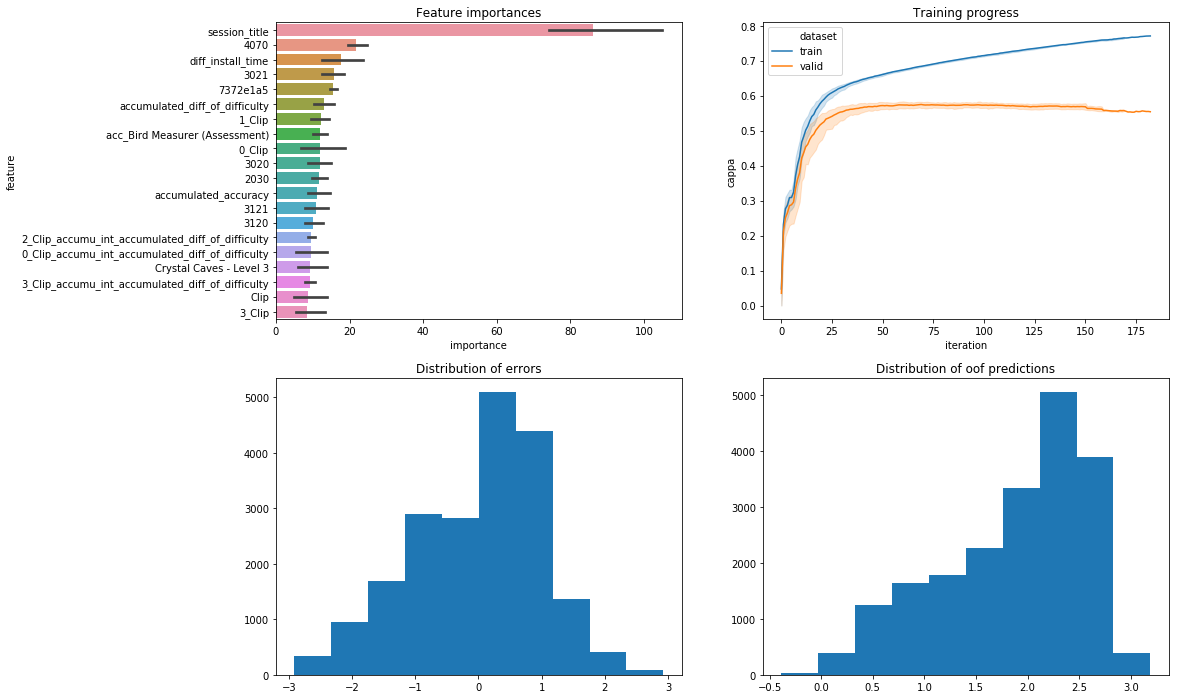

In [43]:
## test込み
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'eval_metric': 'cappa',
    'n_jobs': -1,
    'seed': 42,
    'early_stopping_rounds': 100,
    'n_estimators': 2000,
    'learning_rate': LGB_BO.max['params']['learning_rate'],
    'max_depth': int(LGB_BO.max['params']['max_depth']),
    'lambda_l1': LGB_BO.max['params']['lambda_l1'],
    'lambda_l2': LGB_BO.max['params']['lambda_l2'],
    'bagging_fraction': LGB_BO.max['params']['bagging_fraction'],
    'bagging_freq': int(LGB_BO.max['params']['bagging_freq']),
    'colsample_bytree': LGB_BO.max['params']['colsample_bytree'],
    'verbose': 100
}

mt = MainTransformer(create_interactions=True)
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model.fit(X=reduce_train, 
                    y=y, 
                    folds=folds, 
                    params=params, 
                    preprocesser=mt, 
                    transformers=transformers,
                    eval_metric='cappa', 
                    cols_to_drop=cols_to_drop)

preds_1 = regressor_model.predict(reduce_test)
w_1 = LGB_BO.max['target']

In [ ]:
bounds_LGB = {
    'max_depth': (9, 12),
    'lambda_l1': (0, 10),
    'lambda_l2': (0, 10),
    'bagging_fraction': (0.7, 1),
    'bagging_freq': (6, 12),
    'colsample_bytree': (0.7, 1),
    'learning_rate': (0.07, 0.2),
    'num_leaves': (7, 100)
}

LGB_BO = BayesianOptimization(LGB_bayesian, bounds_LGB, random_state=1030)

with warnings.catch_warnings():
    warnings.filterwarnings('ignore')
    LGB_BO.maximize(init_points=init_points, n_iter=n_iter, acq='ucb', xi=0.0, alpha=1e-6)

|   iter    |  target   | baggin... | baggin... | colsam... | lambda_l1 | lambda_l2 | learni... | max_depth | num_le... |
-------------------------------------------------------------------------------------------------------------------------
|  1        |  0.5746   |  0.8365   |  8.369    |  0.7668   |  6.164    |  9.583    |  0.1706   |  11.34    |  42.47    |
|  2        |  0.5693   |  0.7868   |  7.2      |  0.7178   |  5.357    |  0.5492   |  0.1564   |  9.707    |  93.2     |
|  3        |  0.576    |  0.7805   |  6.923    |  0.9222   |  9.185    |  9.131    |  0.09811  |  10.43    |  62.45    |
|  4        |  0.5735   |  0.749    |  9.47     |  0.8539   |  0.7123   |  8.656    |  0.1905   |  10.86    |  27.66    |
|  5        |  0.573    |  0.792    |  8.999    |  0.7874   |  2.068    |  5.9      |  0.1891   |  10.55    |  54.04    |
|  6        |  0.5731   |  0.8751   |  6.675    |  0.9331   |  8.774    |  1.518    |  0.1684   |  11.38    |  46.52    |
|  7        |  0.5758   

In [ ]:
params = {
    'boosting_type': 'gbdt',
    'metric': 'rmse',
    'objective': 'regression',
    'eval_metric': 'cappa',
    'n_jobs': -1,
    'seed': 42,
    'early_stopping_rounds': 100,
    'n_estimators': 2000,
    'learning_rate': LGB_BO.max['params']['learning_rate'],
    'max_depth': int(LGB_BO.max['params']['max_depth']),
    'lambda_l1': LGB_BO.max['params']['lambda_l1'],
    'lambda_l2': LGB_BO.max['params']['lambda_l2'],
    'bagging_fraction': LGB_BO.max['params']['bagging_fraction'],
    'bagging_freq': int(LGB_BO.max['params']['bagging_freq']),
    'colsample_bytree': LGB_BO.max['params']['colsample_bytree'],
    'verbose': 100
}

mt = MainTransformer()
ft = FeatureTransformer()
transformers = {'ft': ft}
regressor_model = RegressorModel(model_wrapper=LGBWrapper_regr())
regressor_model.fit(X=reduce_train, 
                    y=y, 
                    folds=folds, 
                    params=params, 
                    preprocesser=mt, 
                    transformers=transformers,
                    eval_metric='cappa', 
                    cols_to_drop=cols_to_drop)

preds_2 = regressor_model.predict(reduce_test)
w_2 = LGB_BO.max['target']

In [15]:
del bounds_LGB, LGB_BO, params, mt, ft, transformers, regressor_model
gc.collect()

14983

# Blend and sumbit

In [16]:
preds = (w_1/(w_1+w_2)) * preds_1 + (w_2/(w_1+w_2)) * preds_2

del preds_1, preds_2
gc.collect()

0

In [17]:
coefficients = [1.12232214, 1.73925866, 2.22506454]

In [18]:
preds[preds <= coefficients[0]] = 0
preds[np.where(np.logical_and(preds > coefficients[0], preds <= coefficients[1]))] = 1
preds[np.where(np.logical_and(preds > coefficients[1], preds <= coefficients[2]))] = 2
preds[preds > coefficients[2]] = 3

In [19]:
sample_submission['accuracy_group'] = preds.astype(int)
sample_submission.to_csv('submission.csv', index=False)

In [20]:
sample_submission['accuracy_group'].value_counts(normalize=True)

3    0.438
2    0.259
0    0.154
1    0.149
Name: accuracy_group, dtype: float64